<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson6_MetricsAndFeaturesAdv/FeaturesAdv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с признаками

Будем работать с признаками на примере датасета про Титаник

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Lesson6_MetricsAndFeaturesAdv/titanic_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Lesson6_MetricsAndFeaturesAdv/titanic_test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Fare

Признак `Fare` имеет положительную асимметрию, и уровень выживаемости крайне высок в правой части распределения. Для признака `Fare` использованы 13 квантильных бинов. Хотя количество бинов довольно велико, они дают ощутимую прирост информации. Группы в левой части графика имеют самый низкий уровень выживаемости, а группы в правой части графика — самый высокий. Этот высокий уровень выживаемости не был заметен на графике распределения. Также в процессе был выделен необычный промежуточный бин
$(15.742,23.25]$, который характеризуется высоким уровнем выживаемости.

In [3]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

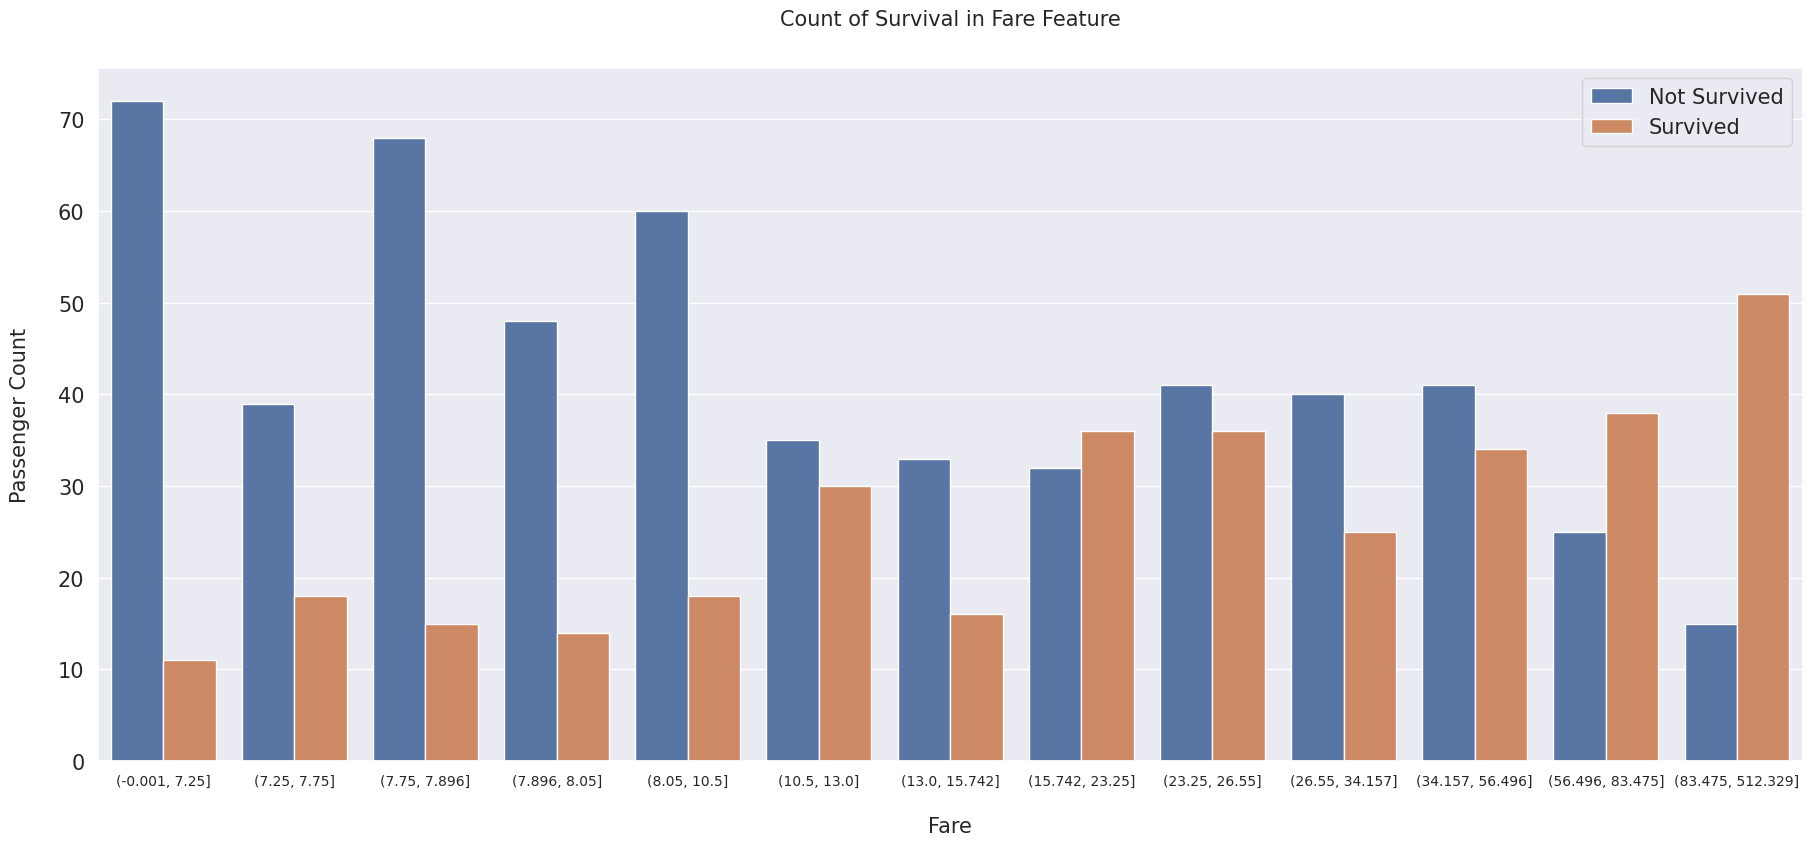

In [4]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### Age

Признак `Age` имеет нормальное распределение с некоторыми выбросами и неровностями. Для признака `Age` использовано 10 квантильных бинов. Первый бин показывает самый высокий уровень выживаемости, а четвёртый бин — самый низкий. Эти значения соответствуют крупнейшим выбросам в распределении. Также был выделен необычный промежуточный бин $(31.0, 36.0]$, который характеризуется высоким уровнем выживаемости.

In [7]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

AssertionError: 

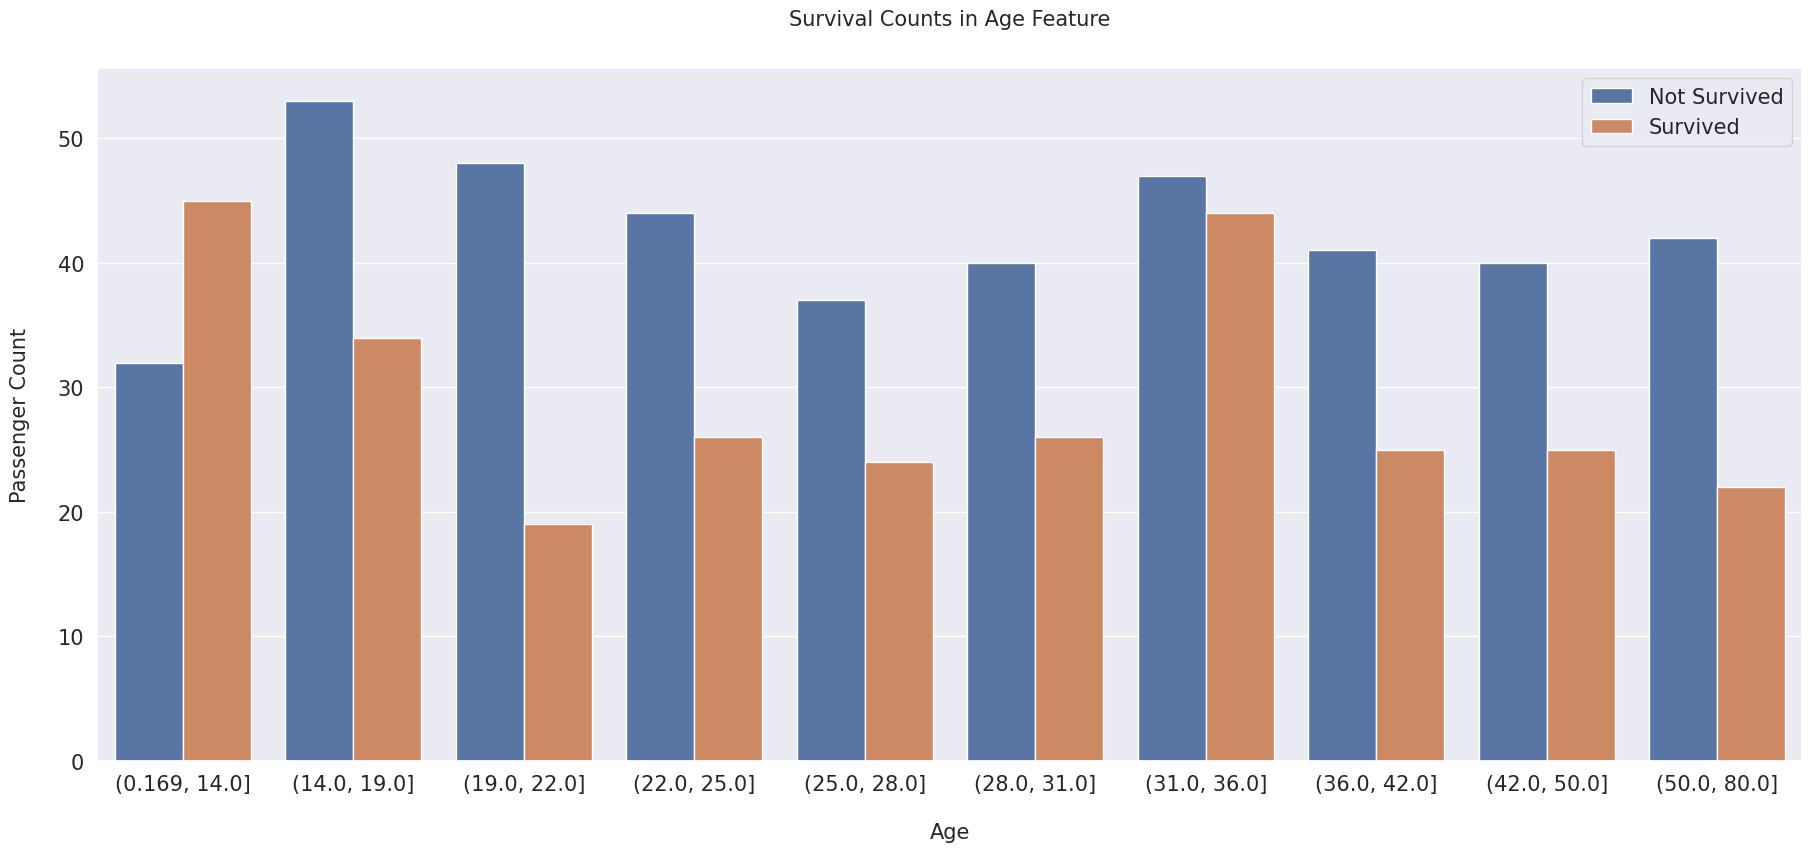

In [8]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### FamilySize

Признак `Family_Size` создается путем сложения значений `SibSp`, `Parch` и добавления 1. `SibSp` — это количество братьев, сестер и супруга(и), а `Parch` — количество родителей и детей. Эти колонки складываются для определения общего размера семьи. Добавление 1 представляет текущего пассажира.

Графики четко показывают, что размер семьи является предиктором выживаемости, так как разные значения имеют разные уровни выживаемости. Размеры семьи классифицируются следующим образом:
- **Family Size** равное 1 обозначается как **Alone** (одинокий);
- **Family Size** равное 2, 3 или 4 обозначается как **Small** (маленькая семья);
- **Family Size** равное 5 или 6 обозначается как **Medium** (средняя семья);
- **Family Size** равное 7, 8 или 11 обозначается как **Large** (большая семья).

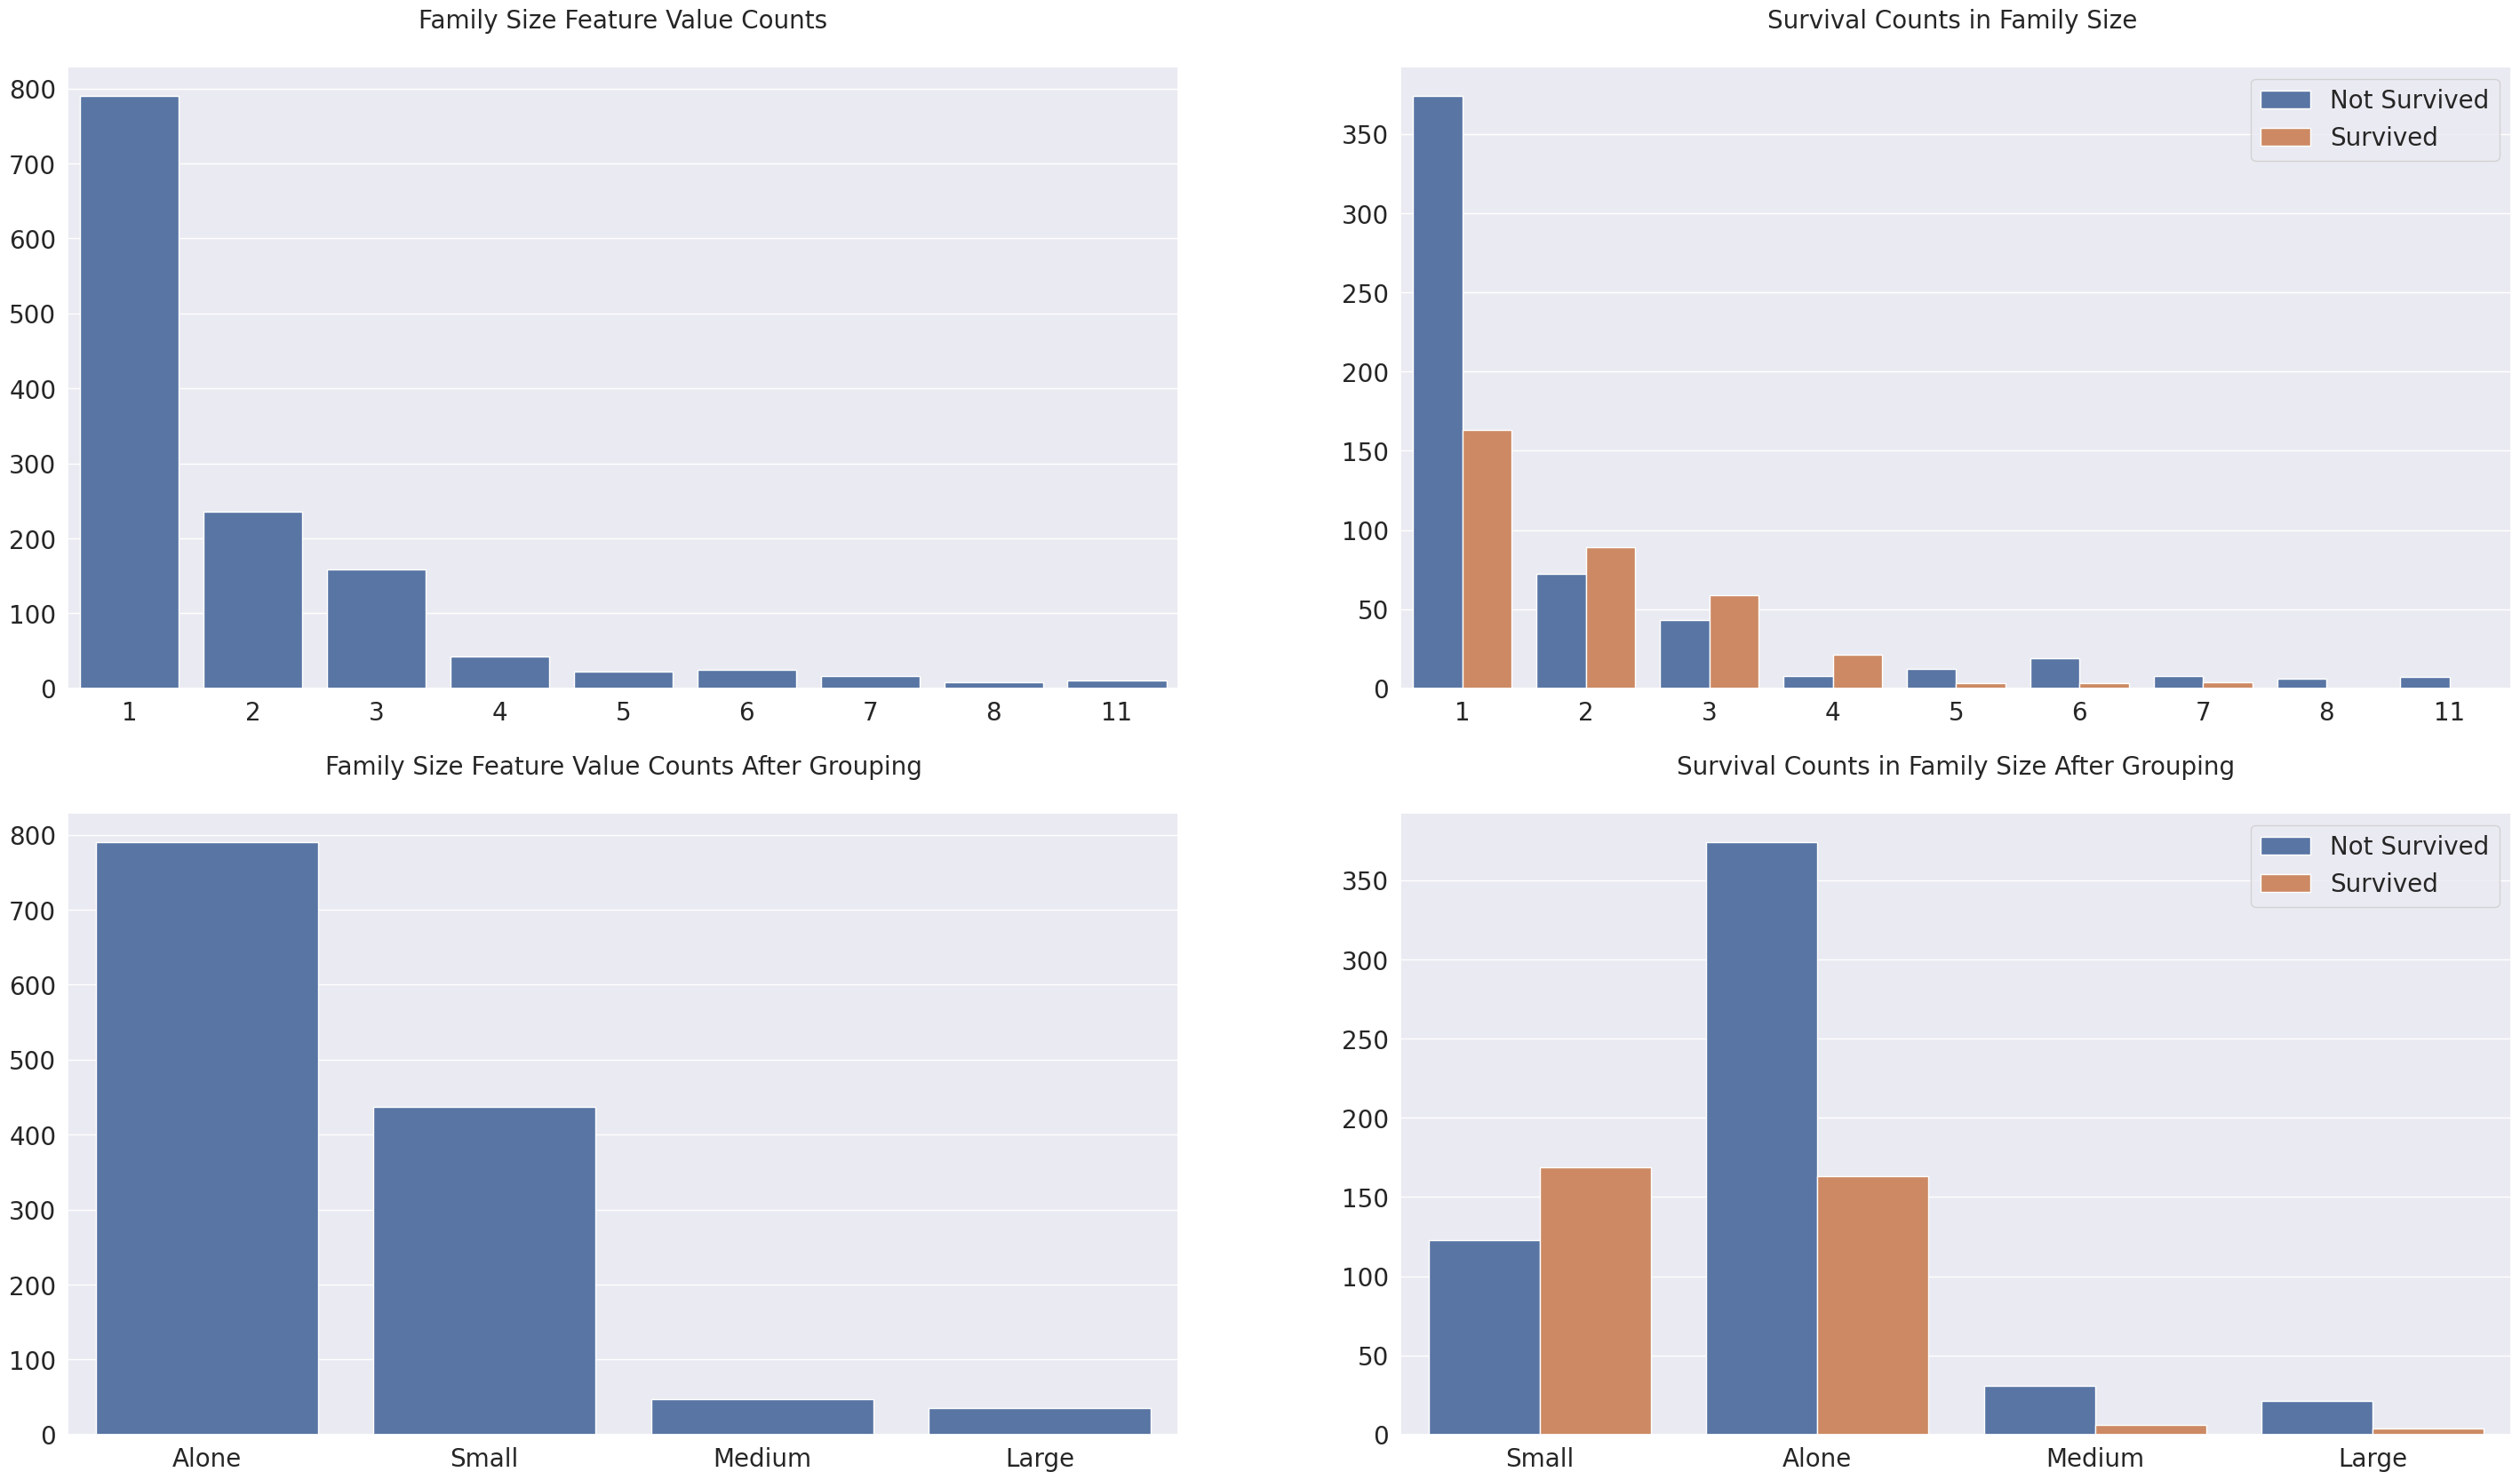

In [9]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

### Ticket

Признак `Ticket` включает слишком много уникальных значений, что делает их прямой анализ сложным. Для упрощения анализа значения билетов группируются по частотам их встречаемости.  

### Чем этот признак отличается от **Family_Size**?  
Признак **Family_Size** отражает количество членов семьи, путешествующих вместе, включая родителей, детей, братьев, сестер и супругов. Однако многие пассажиры путешествовали не только с семьей, но и с другими группами, такими как друзья, няньки, горничные и прочие, которые использовали тот же билет. Эти люди не учитываются в **Family_Size**, но их связь фиксируется через **Ticket_Frequency**.  

### Почему не стоит группировать билеты по их префиксам?  
Если префиксы билетов несут какой-либо смысл, то эта информация уже заложена в признаках **Pclass** (класс каюты) или **Embarked** (порт посадки). Таким образом, дополнительная группировка по префиксам будет избыточной и не даст новых данных.  

### Выводы из графика  
На основании графика:  
- Группы из **2, 3 и 4 человек** имеют более высокий уровень выживаемости.  
- **Одиночные пассажиры** демонстрируют самый низкий уровень выживаемости.  
- После **4 человек в группе** уровень выживаемости резко снижается.  

Этот паттерн схож с **Family_Size**, однако между ними есть некоторые различия, так как **Ticket_Frequency** включает как семейные, так и несемейные группы.  

### Почему **Ticket_Frequency** не группируется так же, как **Family_Size**?  
Если бы значения **Ticket_Frequency** были сгруппированы аналогично **Family_Size**, это привело бы к созданию практически идентичного признака с высокой корреляцией. Такой признак не добавил бы новой информации и был бы бесполезен для модели. Поэтому обработка **Ticket_Frequency** выполняется отдельно, чтобы сохранить уникальную информацию, связанную с билетами.

In [10]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

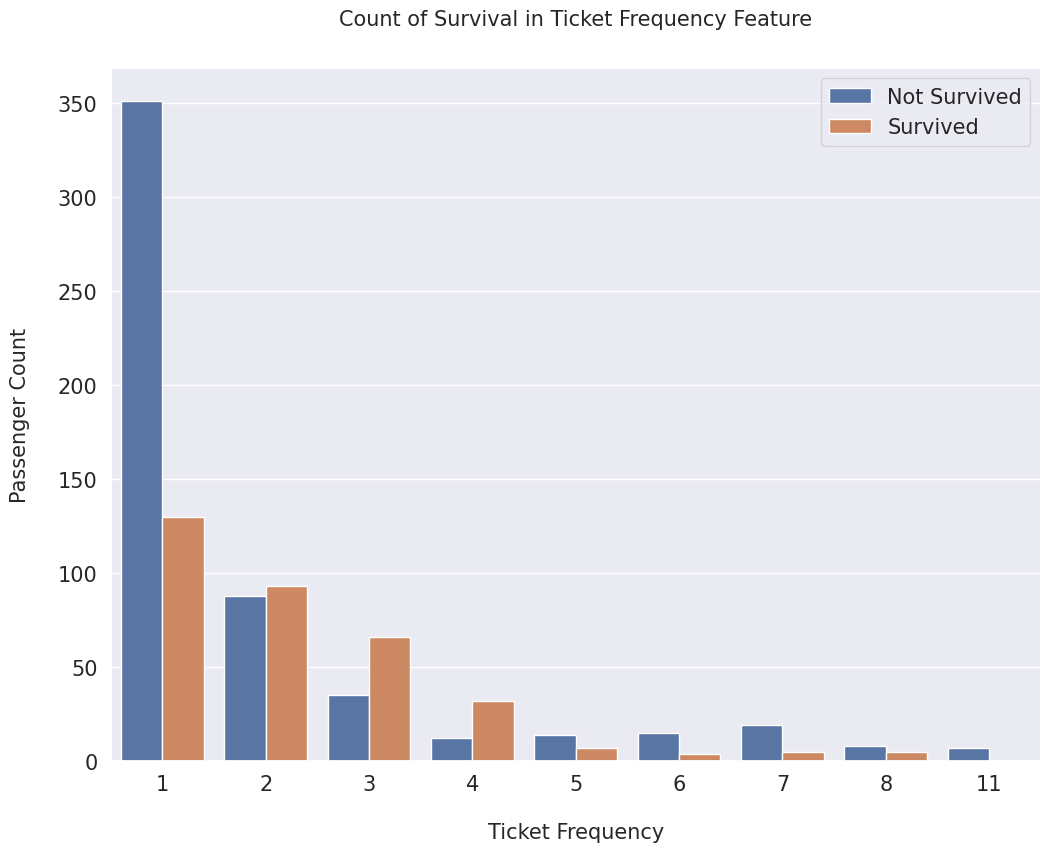

In [11]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### Title & IsMarried

Признак `Title` создается путем извлечения префикса перед именем из признака `Name`.  

### Обработка редких и некорректных значений  
Согласно графику, некоторые титулы встречаются очень редко или выглядят некорректно. Для упрощения и корректности анализа выполнены следующие преобразования:  
- **Женские титулы**:  
  - Титулы **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** заменяются на общую группу **Miss/Mrs/Ms**, так как они соответствуют женщинам.  
  - Примечание: Титулы **Mlle**, **Mme** и **Dona** изначально являются частью имен, но классифицированы как титулы из-за разделения признака **Name** по запятой.  
- **Мужские и профессиональные титулы**:  
  - Титулы **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don**, **Rev** заменяются на общую категорию **Dr/Military/Noble/Clergy**, так как пассажиры с такими титулами имеют схожие характеристики.  

### Особый случай: Master  
Титул **Master** выделяется отдельно, так как он дается мужчинам младше 26 лет. Эти пассажиры демонстрируют самый высокий уровень выживаемости среди всех мужчин.  

### Признак **Is_Married**  
**Is_Married** — бинарный признак, основанный на титуле **Mrs**, который характерен для замужних женщин.  
- Титул **Mrs** демонстрирует самый высокий уровень выживаемости среди всех женских титулов.  
- Добавление признака **Is_Married** важно, так как женские титулы объединены в одну группу, и наличие отдельного индикатора для замужних женщин позволяет модели лучше учитывать различия внутри этой группы.  

In [12]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

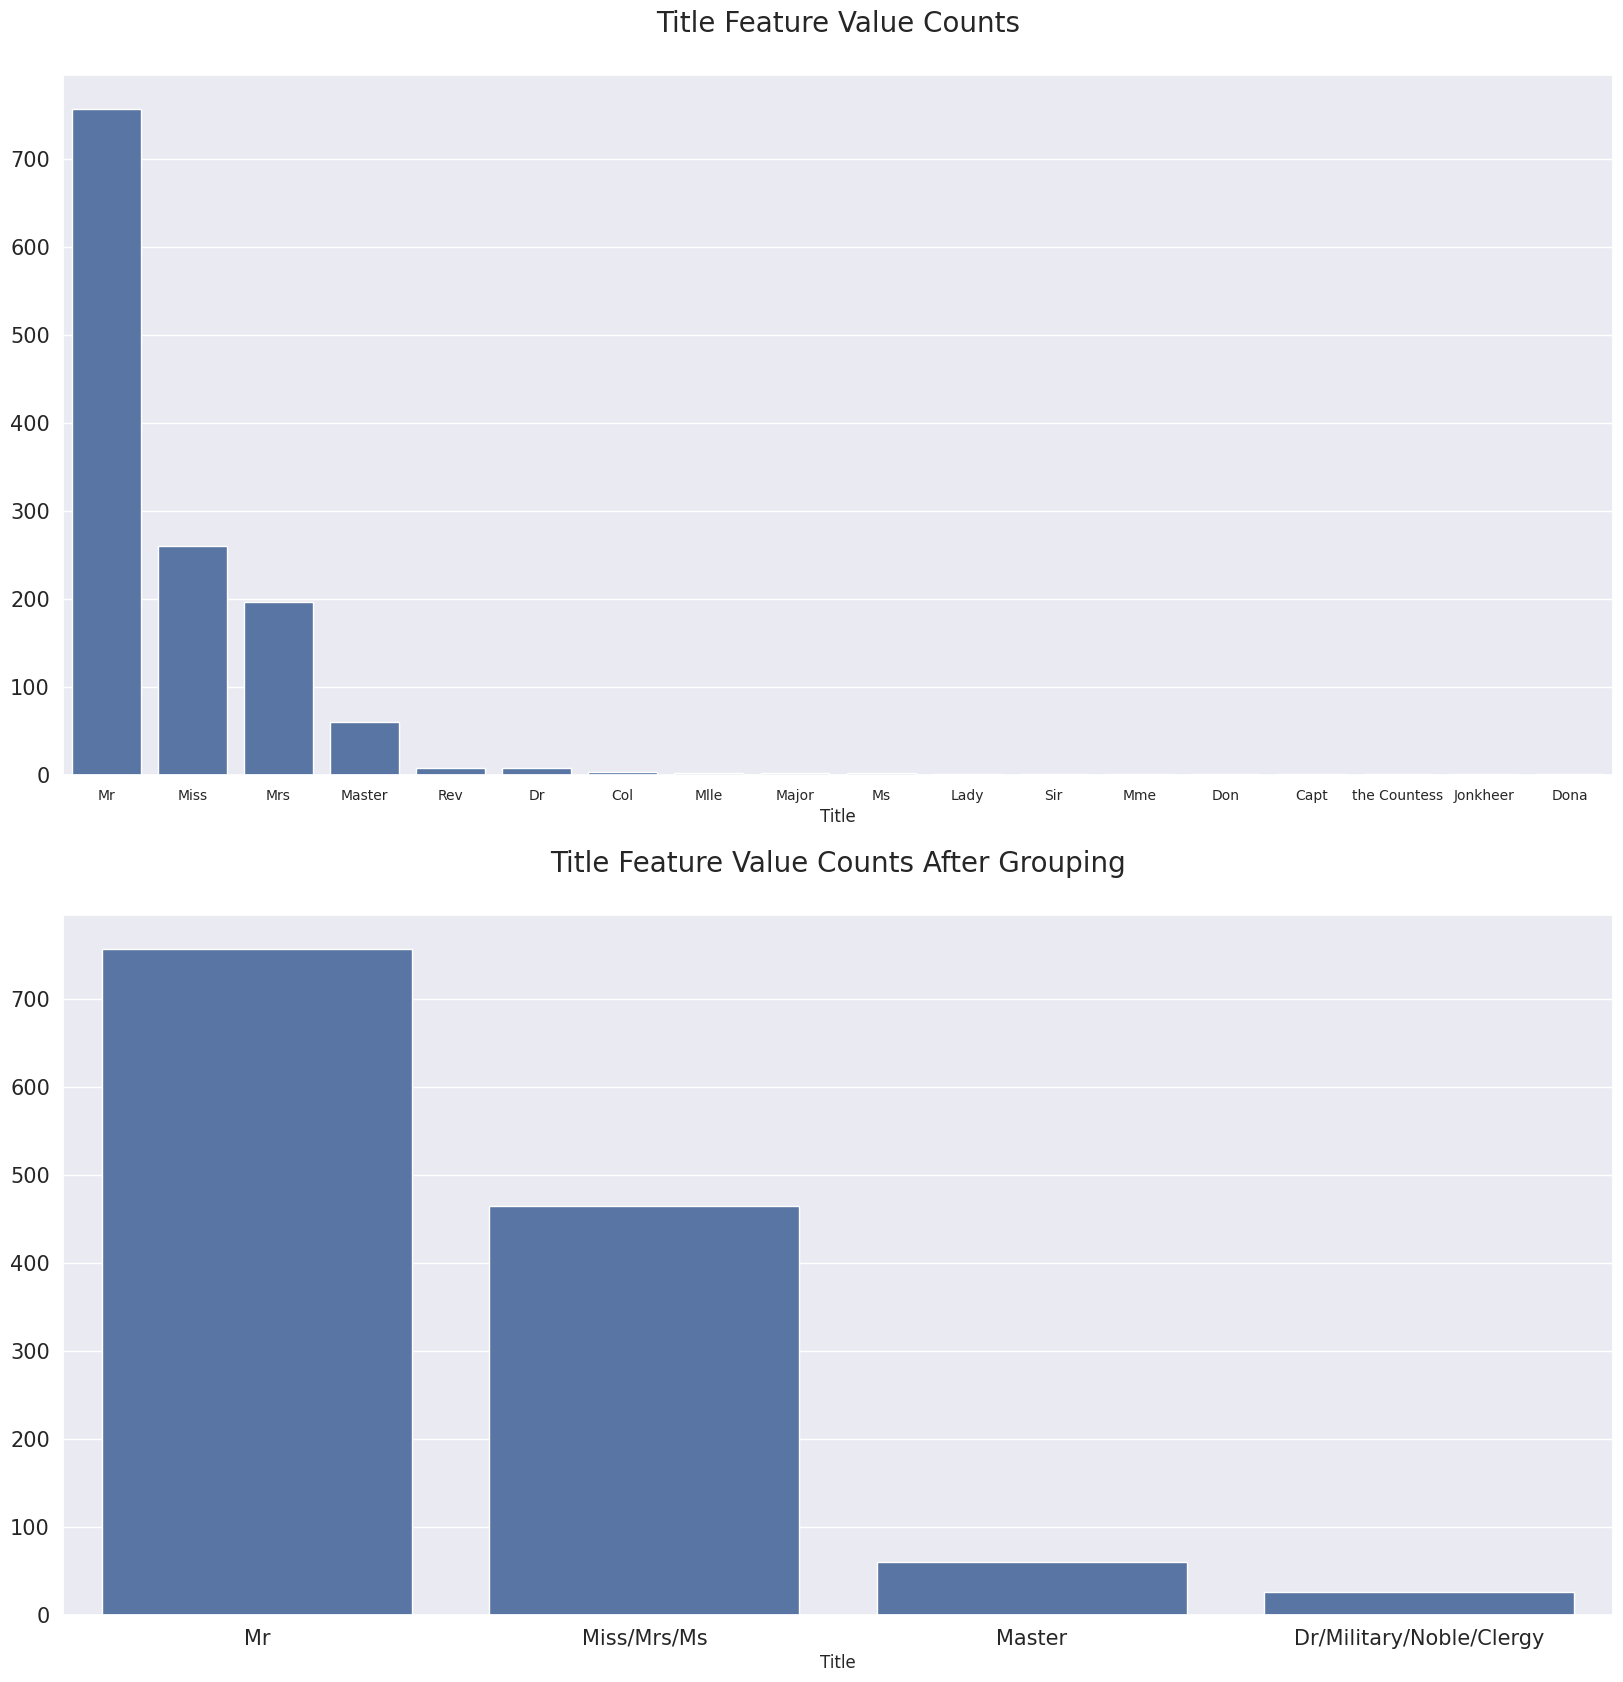

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### Target Encoding

Функция **extract_surname** используется для извлечения фамилии пассажира из признака **Name**.  

### Создание признака **Family**  
Признак **Family** создается на основе извлеченной фамилии, чтобы сгруппировать пассажиров, принадлежащих к одной семье.  

### Зачем нужен признак **Family**?  
- Этот признак позволяет выявить пассажиров, которые путешествовали вместе как члены одной семьи.  
- Это особенно полезно для анализа группового поведения, например, уровня выживаемости внутри одной семьи.  

In [16]:
def extract_surname(data):

    families = []

    for i in range(len(data)):
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]

        for c in string.punctuation:
            family = family.replace(c, '').strip()

        families.append(family)

    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

### Расчет **Family_Survival_Rate**  
1. **Источник данных**: Поскольку признак **Survived** доступен только в обучающем наборе данных, расчет семейного уровня выживаемости основан на данных из тренировочного набора.  
2. **Общие семьи между наборами**: Создается список фамилий (**non_unique_families**), которые встречаются как в тренировочном, так и в тестовом наборе данных.  
3. **Условие для расчета**: Для семей с более чем одним членом из списка **non_unique_families** рассчитывается средний уровень выживаемости (**Family_Survival_Rate**) и сохраняется в новом признаке.  

### Дополнительный признак **Family_Survival_Rate_NA**  
Для семей, уникальных для тестового набора данных, создается бинарный признак **Family_Survival_Rate_NA**.  
- **Зачем он нужен?**  
  Для таких семей невозможно рассчитать уровень выживаемости, так как данные о выживаемости отсутствуют. Этот признак указывает, что уровень выживаемости семьи недоступен.  

---

### Расчет **Ticket_Survival_Rate**  
Аналогичная методология применяется для билетов:  
- **Ticket_Survival_Rate** рассчитывается для пассажиров, использующих один и тот же билет.  
- **Ticket_Survival_Rate_NA** создается для пассажиров, чей билет уникален для тестового набора, где расчет уровня выживаемости невозможен.  

---

### Объединение признаков  
1. **Survival_Rate**:  
   Рассчитывается как среднее значение между **Family_Survival_Rate** и **Ticket_Survival_Rate**.  
2. **Survival_Rate_NA**:  
   Рассчитывается как среднее значение между **Family_Survival_Rate_NA** и **Ticket_Survival_Rate_NA**.  

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [17]:
df_train['Family']

,Family
0,Braund
1,Cumings
2,Heikkinen
3,Futrelle
4,Allen
...,...
886,Montvila
887,Graham
888,Johnston
889,Behr


In [18]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')[['Survived', 'Family_Size']].median()
df_ticket_survival_rate = df_train.groupby('Ticket')[['Survived', 'Ticket_Frequency']].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [19]:
ticket_rates

{'110813': 1.0,
 '112058': 0.0,
 '113059': 0.0,
 '113503': 0.0,
 '113509': 0.0,
 '113773': 0.0,
 '113781': 0.5,
 '113796': 0.0,
 '11753': 1.0,
 '11765': 1.0,
 '11767': 1.0,
 '11769': 1.0,
 '11813': 1.0,
 '12749': 1.0,
 '13567': 1.0,
 '1601': 1.0,
 '16966': 1.0,
 '17463': 0.0,
 '17464': 1.0,
 '19877': 0.5,
 '19928': 0.5,
 '19950': 0.5,
 '2003': 1.0,
 '220845': 1.0,
 '226875': 1.0,
 '228414': 1.0,
 '230136': 1.0,
 '236853': 0.0,
 '237789': 1.0,
 '24160': 1.0,
 '244358': 0.0,
 '248738': 1.0,
 '250651': 0.0,
 '2625': 1.0,
 '26360': 1.0,
 '2650': 1.0,
 '2653': 1.0,
 '2661': 1.0,
 '2662': 0.0,
 '2668': 1.0,
 '26707': 0.0,
 '2678': 0.0,
 '2680': 0.0,
 '2689': 0.0,
 '28220': 1.0,
 '28664': 0.0,
 '29103': 1.0,
 '29105': 1.0,
 '2926': 1.0,
 '29750': 0.5,
 '3101295': 0.0,
 '3101298': 1.0,
 '315153': 1.0,
 '33638': 1.0,
 '345572': 1.0,
 '345763': 0.0,
 '347077': 1.0,
 '347080': 0.0,
 '349256': 1.0,
 '349909': 0.0,
 '349910': 0.0,
 '350026': 0.0,
 '364498': 0.0,
 '36568': 0.0,
 '367226': 1.0,
 '369

In [30]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)

df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)

df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [31]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2

### Признак `Deck`

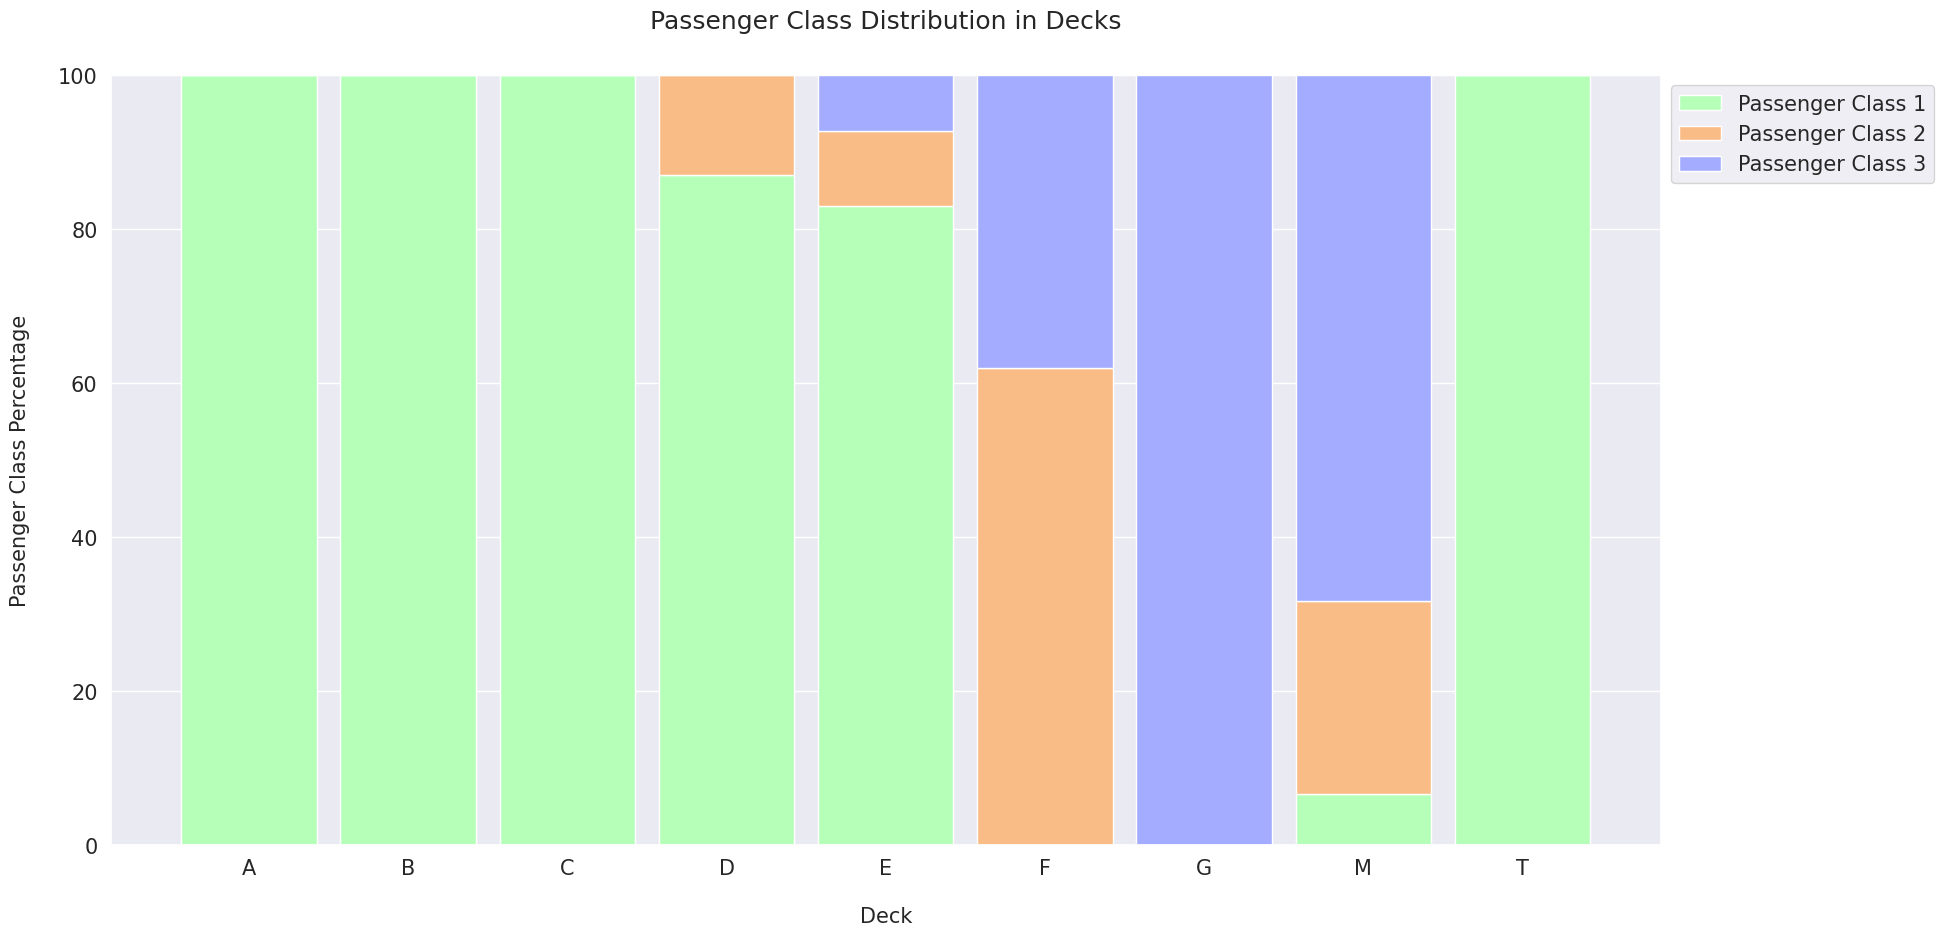

In [22]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch',
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):

    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):

    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)

    plt.show()

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [23]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [24]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

,count
Deck,
M,1014
ABC,182
DE,87
FG,26


In [25]:
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

### Преобразование категориальных признаков с помощью **LabelEncoder**  

#### Исходные типы признаков:
- **Object-type**:  
  Признаки **Embarked**, **Sex**, **Deck**, **Title** и **Family_Size_Grouped** имеют текстовый (строковый) формат данных.  
- **Category-type**:  
  Признаки **Age** и **Fare** имеют категориальный тип.  

#### Зачем преобразование?  
Большинство моделей машинного обучения работают только с числовыми данными. Чтобы модели могли "обучаться" на этих признаках, текстовые и категориальные значения необходимо преобразовать в числовую форму.  

#### Использование **LabelEncoder**  
- **LabelEncoder** присваивает каждому классу (уникальному значению) числовую метку от `0` до `n-1`, где `n` — общее количество уникальных классов в признаке.  
- Пример:  
  - Для признака **Sex** значения `"male"` и `"female"` будут преобразованы в `0` и `1`.  
  - Для признака **Embarked** значения `"C"`, `"Q"`, `"S"` будут преобразованы в `0`, `1`, `2`.  

In [27]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

### One-Hot Encoding

Признаки для преобразования:

`Pclass`

`Sex`

`Deck`

`Embarked`

`Title`

Эти признаки являются категориальными, поэтому их следует преобразовать с помощью OneHotEncoder.

In [28]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

## Заключение по работе с признаками

### Подготовка данных и создание новых признаков

Процесс предобработки данных включал несколько ключевых шагов для улучшения качества модели. Ниже перечислены основные этапы и их описание.

---

### 1. **Бинирование признаков Age и Fare**
- **Age** и **Fare** были разбиты на интервалы (биннинг), что помогло:
  - Справиться с выбросами, исключив влияние крайне высоких или низких значений.
  - Выявить гомогенные группы, что могло улучшить способность модели выявлять закономерности в выживаемости.
  
---

### 2. **Создание признака Family_Size**
- **Family_Size** вычисляется как сумма признаков **Parch** (количество родителей/детей) и **SibSp** (количество братьев/сестер и супругов), с добавлением `1` для самого пассажира.
- Это позволяет классифицировать пассажиров по размерам их семей, что полезно для анализа выживаемости внутри семейных групп.

---

### 3. **Создание признака Ticket_Frequency**
- **Ticket_Frequency** создается путем подсчета частоты повторяющихся значений в признаке **Ticket**.  
- Это позволяет учитывать, сколько людей путешествовало с тем же билетом, что может быть полезным для выявления паттернов выживаемости среди групп пассажиров.

---

### 4. **Использование признака Name**
Признак **Name** очень полезен для извлечения дополнительной информации:

- **Title** и **Is_Married**:
  - Извлечение титула (например, **Mr**, **Mrs**, **Miss**, и т.д.) из префикса имени.
  - На основе титула также создается бинарный признак **Is_Married**, указывающий, является ли пассажир замужем (т.е. если титул **Mrs**).

- **Family_Survival_Rate** и **Family_Survival_Rate_NA**:
  - Эти признаки создаются с использованием **сурнейм** (фамилии) пассажиров. Для каждого пассажира вычисляется **Family_Survival_Rate** через **target encoding** фамилии (средний уровень выживаемости для семей с одинаковыми фамилиями).
  - Для тех фамилий, которые встречаются только в тестовом наборе (и для которых нельзя вычислить уровень выживаемости), создается признак **Family_Survival_Rate_NA**, который указывает, что для этой семьи нет доступной информации о выживаемости.

- **Ticket_Survival_Rate**:
  - Похожий процесс применяется для признака **Ticket**, где **Ticket_Survival_Rate** вычисляется через **target encoding** на основе повторяющихся номеров билетов.

- **Survival_Rate**:
  - Этот признак создается путем усреднения **Family_Survival_Rate** и **Ticket_Survival_Rate**, чтобы объединить информацию о выживаемости, основанную на принадлежности пассажира к определенной семье или группе.

---

### 5. **Приведение категориальных признаков к числовому виду**
После создания новых признаков, оставшиеся категориальные признаки были обработаны следующим образом:
- **Label Encoding** был применен к признакам, которые являются категориальными, но имеют порядок (например, **Pclass**, **Sex**, **Deck**, **Embarked**), чтобы преобразовать их в числовые значения.
- **One-Hot Encoding** был применен к категориальным признакам, таким как **Title** и **Family_Size_Grouped**, чтобы создать бинарные столбцы для каждой категории.

---

### 6. **Удаление бесполезных признаков**
После того как признаки были закодированы, бесполезные или избыточные признаки были удалены:
- Признаки, которые больше не несли информацию или были дублирующими, например, исходные текстовые столбцы или те, которые избыточны после применения **target encoding**.

---

### Итоговые шаги:
- **Создано 5 новых признаков**: **Family_Size**, **Title**, **Is_Married**, **Survival_Rate**, и **Survival_Rate_NA**.
- **Была проведена кодировка категориальных признаков** с использованием **LabelEncoder** и **OneHotEncoder**.
- **Удалены ненужные признаки** после кодирования, чтобы оставить только полезную информацию для обучения модели.

Эта обработка данных значительно улучшает способность модели анализировать и предсказывать выживаемость пассажиров, основанную на семейной и групповой информации, а также на личных характеристиках пассажиров.

In [32]:
df_all = concat_df(df_train, df_test)

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Embarked_4,Family_Size_Grouped_1,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


### Model

In [33]:
X_train = df_train.drop(columns=drop_cols)
y_train = df_train['Survived']

X_train.head()

,Age,Fare,Ticket_Frequency,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Deck_1,...,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Survival_Rate,Survival_Rate_NA
0,2,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.383838,0.0
1,7,11,2,1,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0
2,4,3,1,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.383838,0.0
3,6,10,2,1,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.383838,0.0
4,6,3,1,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.383838,0.0


In [34]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [35]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

model = CatBoostClassifier(verbose=0)

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv = cross_val_score(model, X_train, y_train, cv=stratified_kfold, scoring='accuracy')
print(cv)
print(cv.mean())

[0.85521886 0.85521886 0.85858586]
0.8563411896745231


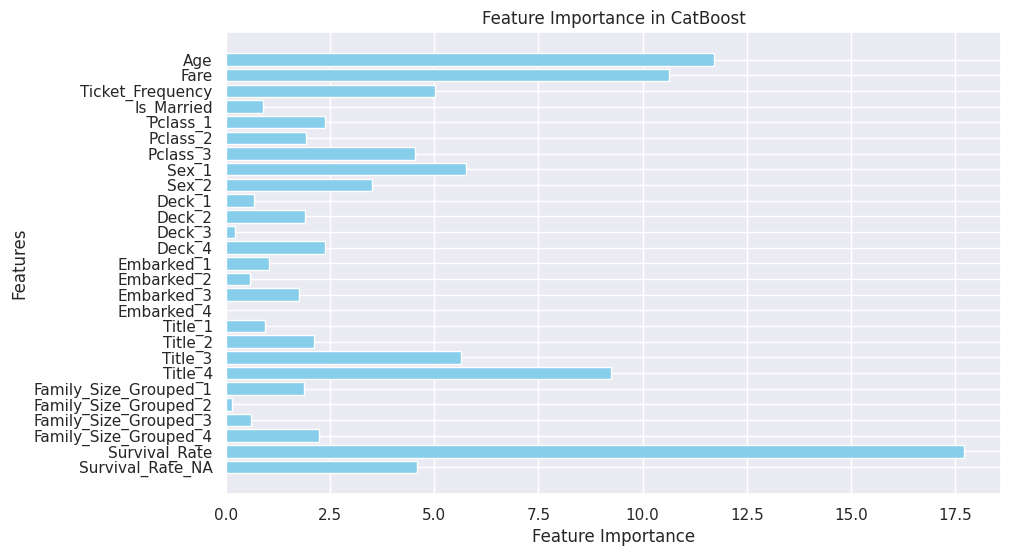

In [36]:
model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

# Получение важности признаков
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost")
plt.gca().invert_yaxis()  # Инвертировать ось для наглядности
plt.show()

In [39]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Lesson6_MetricsAndFeaturesAdv/titanic_train.csv')
df_orig.head()

X_train_orig = df_orig.drop('Survived', axis=1)
y_train_orig = df_orig['Survived']

X_train_orig.drop(['PassengerId'], axis=1, inplace=True)

In [40]:
X_train_orig.fillna('NA', inplace=True)

In [41]:
model_zero = CatBoostClassifier(cat_features = ['Name','Sex','Ticket','Cabin','Embarked'], verbose=0)

cv = cross_val_score(model_zero, X_train_orig, y_train_orig, cv=stratified_kfold, scoring='accuracy')
print(cv)
print(cv.mean())

[0.83164983 0.83164983 0.83838384]
0.8338945005611672


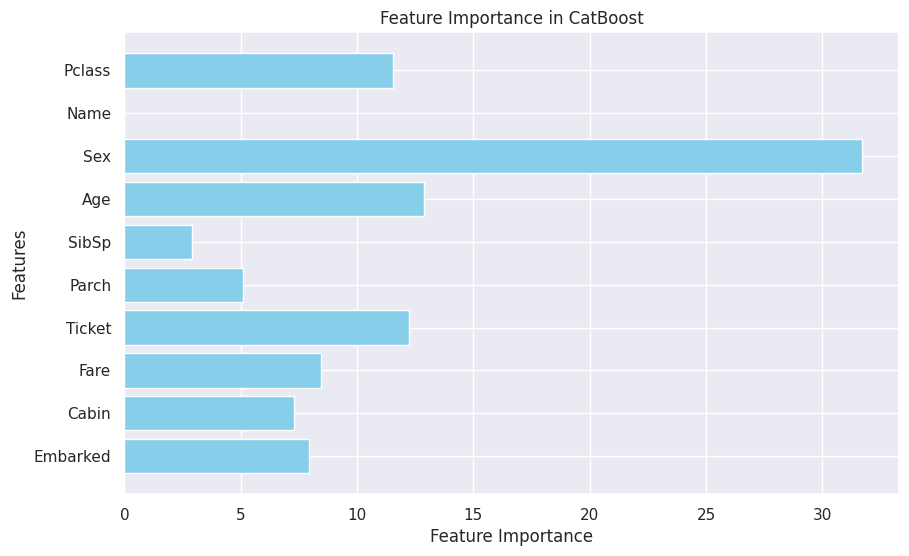

In [42]:
model_zero.fit(X_train_orig, y_train_orig)

# Получение важности признаков
feature_importances = model_zero.get_feature_importance()
feature_names = X_train_orig.columns

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost")
plt.gca().invert_yaxis()  # Инвертировать ось для наглядности
plt.show()

## Выводы из результатов модели

* Работа с признаками улучшает качество прогноза
* Есть переобучение на кросс-валидации (можно делать аккуратнее)